# Transfer learning with TensorFlow Hub


[TensorFlow Hub](http://tensorflow.org/hub) is a way to share pretrained model components. See the [TensorFlow Module Hub](https://tfhub.dev/) for a searchable listing of pre-trained models.



## 1. Setup

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import matplotlib.pylab as plt

try:
  # %tensorflow_version only exists in Colab.
  !pip install -q tf-nightly
except Exception:
    pass
import tensorflow as tf

ERROR: tf-nightly-2-0-preview 2.0.0.dev20191002 has requirement gast==0.2.2, but you'll have gast 0.3.2 which is incompatible.
ERROR: tf-nightly-2-0-preview 2.0.0.dev20191002 has requirement tb-nightly<2.2.0a0,>=2.1.0a0, but you'll have tb-nightly 2.2.0a20200106 which is incompatible.
ERROR: tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.2 which is incompatible.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [2]:
!pip install -q -U tf-hub-nightly
import tensorflow_hub as hub

from tensorflow.keras import layers
import csv


You should consider upgrading via the 'python -m pip install --upgrade pip' command.


# 2. Load dataset


The simplest way to load this data into our model is using `tf.keras.preprocessing.image.ImageDataGenerator`,

All of TensorFlow Hub's image modules expect float inputs in the `[0, 1]` range. Use the `ImageDataGenerator`'s `rescale` parameter to achieve this.

The image size will be handled later.

### Load train and test dataset, if split is done before augmentig data

In [5]:
# Load Training data

# featurewise_std_normalization
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data_train = image_generator.flow_from_directory('../data/dataset/spectrograms512_train', class_mode="categorical", batch_size=32, target_size=(512, 512), save_to_dir = "../data/dataset/spectrograms512_train_temp")

Found 9600 images belonging to 10 classes.


In [6]:
labels_train = (image_data_train.class_indices)
labels_train

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

In [7]:
#Load test data

# featurewise_std_normalization
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data_test = image_generator.flow_from_directory('../data/dataset/spectrograms512_test', class_mode="categorical", batch_size=32, target_size=(512, 512), save_to_dir = "../data/dataset/spectrograms512_train_temp")

Found 600 images belonging to 10 classes.


In [8]:
labels_test = (image_data_test.class_indices)
labels_test

{'blues': 0,
 'classical': 1,
 'country': 2,
 'disco': 3,
 'hiphop': 4,
 'jazz': 5,
 'metal': 6,
 'pop': 7,
 'reggae': 8,
 'rock': 9}

The resulting object is an iterator that returns `image_batch, label_batch` pairs.

# 3. Download the headless model

Using TF Hub it is simple to retrain the top layer of the model to recognize the classes in our dataset.

TensorFlow Hub also distributes models without the top classification layer. These can be used to easily do transfer learning.

Any [Tensorflow 2 compatible image feature vector URL](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) from tfhub.dev will work here.

In [9]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"


Create the feature extractor.

In [10]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url)
feature_extractor_layer.trainable = True


Freeze the variables in the feature extractor layer, so that the training only modifies the new classifier layer.

In [11]:
feature_extractor_layer.trainable = True

# 4. Attach a classification head

Now wrap the hub layer in a `tf.keras.Sequential` model, and add a new classification layer.

In [13]:

model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dropout(rate=0.2),
  layers.Dense(image_data_test.num_classes, activation='softmax', name = "class_layer")
])

model.build((None,512,512,3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
extra_input_convolution (Con (None, 224, 224, 3)       38028     
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
class_layer (Dense)          (None, 10)                12810     
Total params: 2,308,822
Trainable params: 2,274,710
Non-trainable params: 34,112
_________________________________________________________________


# 5. Train the model

Use compile to configure the training process:

In [14]:
model.compile(
      optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.01),
      loss='categorical_crossentropy',
      metrics=['acc'])

Now use the `.fit` method to train the model.

To visualize the training progress, use a custom callback to log the loss and accuracy of each epoch.

In [15]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    self.batch_acc_test = []
    self.batch_losses_test = []


    
  def on_epoch_end (self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.batch_acc_test.append(logs['val_acc'])
    self.batch_losses_test.append(logs['val_loss'])
    self.model.reset_metrics()

### Train (it will take some time...)

In [16]:

# train model
# https://www.geeksforgeeks.org/keras-fit-and-keras-fit_generator/

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data_train,
                   steps_per_epoch = 25,
                   validation_data = image_data_test,
                   validation_steps = 18,
                   callbacks = [batch_stats_callback],
                   max_queue_size = 10,
                   epochs = 100,
                   ) 

Epoch 1/100
25/25 [==============================] - 2376s 95s/step - loss: 2.0342 - acc: 0.3475 - val_loss: 2.5101 - val_acc: 0.2049
Epoch 2/100
25/25 [==============================] - 2655s 106s/step - loss: 1.6179 - acc: 0.4850 - val_loss: 2.8380 - val_acc: 0.1076
Epoch 3/100
25/25 [==============================] - 2701s 108s/step - loss: 1.3348 - acc: 0.5713 - val_loss: 2.8119 - val_acc: 0.1684
Epoch 4/100
25/25 [==============================] - 2658s 106s/step - loss: 1.2199 - acc: 0.6187 - val_loss: 2.4536 - val_acc: 0.2031
Epoch 5/100
25/25 [==============================] - 2627s 105s/step - loss: 1.1426 - acc: 0.6425 - val_loss: 2.9071 - val_acc: 0.1597
Epoch 6/100
25/25 [==============================] - 2545s 102s/step - loss: 0.9724 - acc: 0.7025 - val_loss: 2.4756 - val_acc: 0.2135
Epoch 7/100
25/25 [==============================] - 2545s 102s/step - loss: 0.9528 - acc: 0.6938 - val_loss: 1.4069 - val_acc: 0.5434
Epoch 8/100
25/25 [==============================] - 254

KeyboardInterrupt: 

# 6. Plot accuracy and loss

Now after, even just a few training iterations, we can already see that the model is making progress on the task.

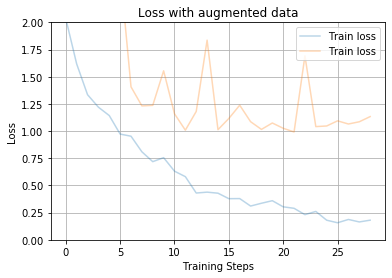

In [17]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses, label= 'Train loss', alpha=0.3)
plt.plot(batch_stats_callback.batch_losses_test, label= 'Train loss', alpha=0.3)
plt.legend(loc="upper right")
plt.title("Loss with augmented data")
plt.grid(True)

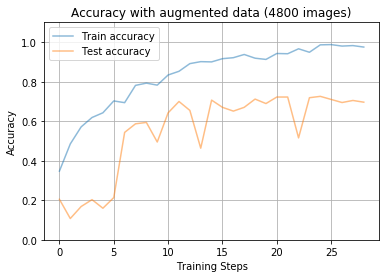

In [18]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1.1])
plt.plot(batch_stats_callback.batch_acc, label= 'Train accuracy', alpha=0.5)
plt.plot(batch_stats_callback.batch_acc_test, label= 'Test accuracy', alpha=0.5)
plt.legend(loc="upper left")
plt.title("Accuracy with augmented data (4800 images)")
plt.grid(True)

# 8. Export results

In [ ]:
path = '../data/'
print('Exporting results')

# Record training progress
with open(path+'results.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(["epoch", "loss", "accuracy", "val_loss", "val_accuracy"])

    for line in range(len(batch_stats_callback.batch_losses)):
        writer.writerow([line,
                         batch_stats_callback.batch_losses[line],
                         batch_stats_callback.batch_acc[line],
                         batch_stats_callback.batch_losses_test[line],
                         batch_stats_callback.batch_acc_test[line],
                         ])
    file.close()

print('Done')

# 9. Export your model

Now that you've trained the model, export it as a saved model:

In [ ]:
import time
t = time.time()

export_path = "/tmp/saved_models/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

Now confirm that we can reload it, and it still gives the same results:

In [ ]:
reloaded = tf.keras.models.load_model(export_path)

In [ ]:
result_batch = model.predict(image_batch)
reloaded_result_batch = reloaded.predict(image_batch)

In [ ]:
abs(reloaded_result_batch - result_batch).max()

This saved model can loaded for inference later, or converted to [TFLite](https://www.tensorflow.org/lite/convert/) or [TFjs](https://github.com/tensorflow/tfjs-converter).

